<a href="https://colab.research.google.com/github/khiempm209/Deakin-SIT742-Ass2/blob/Jeff/SIT742_A2_Part1_Jeff.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

###Question 1.1

In [ ]:
import os

# Delete the downloaded and extracted files if they exist
if os.path.exists(gz_file_path):
    os.remove(gz_file_path)

if os.path.exists(csv_file_path):
    os.remove(csv_file_path)


# Clear all variables in the current environment
for var in list(globals().keys()):
    if var[0] != "_":  # Avoid deleting internal variables
        del globals()[var]

from IPython.display import clear_output
clear_output(wait=True)


The purpose of the following code is to download, extract, and process a .gz compressed file containing transaction data, and then analyze it using PySpark.

First, it installs PySpark using !pip install pyspark to enable the necessary libraries for distributed data processing.

Then, it uses the requests library to download a compressed .gz file from a specified URL, saving it locally. The .gz file is extracted using the gzip and shutil modules, producing a .csv file.

Afterward, a Spark session is initiated to enable data processing in a distributed environment. Finally, the extracted CSV file is loaded into a PySpark DataFrame for further analysis.

In [ ]:
!pip install pyspark

import requests
import gzip
import shutil
from pyspark.sql import SparkSession
from pyspark.sql.functions import regexp_replace, col

# Download the .gz file
url = "https://github.com/tulip-lab/sit742/blob/develop/Assessment/2024/data/transactionrecord.gz?raw=true"
gz_file_path = "/content/transactionrecord.gz"
csv_file_path = "/content/transactionrecord.csv"

# Download the file
response = requests.get(url, stream=True)
with open(gz_file_path, "wb") as f:
    f.write(response.content)

# Extract the .gz file
with gzip.open(gz_file_path, 'rb') as f_in:
    with open(csv_file_path, 'wb') as f_out:
        shutil.copyfileobj(f_in, f_out)

# Start a Spark session
spark = SparkSession.builder.appName("DataWrangling").getOrCreate()

# Load the extracted CSV data
df = spark.read.csv(csv_file_path, header=True, inferSchema=True)



In [ ]:
# Print the schema and columns to see the column names and types
df.printSchema()
print(df.columns)

root
 |-- TransactionNo: string (nullable = true)
 |-- Date: string (nullable = true)
 |-- ProductNo: string (nullable = true)
 |-- ProductName: string (nullable = true)
 |-- Product_category: string (nullable = true)
 |-- Price: double (nullable = true)
 |-- Quantity: integer (nullable = true)
 |-- CustomerNo: integer (nullable = true)
 |-- Country: string (nullable = true)

['TransactionNo', 'Date', 'ProductNo', 'ProductName', 'Product_category', 'Price', 'Quantity', 'CustomerNo', 'Country']


In [ ]:
# Show the first 5 rows
df.select('TransactionNo', 'Date', 'ProductNo', 'ProductName', 'Product_category', 'Price', 'Quantity', 'CustomerNo', 'Country').show(5)

+-------------+---------+---------+--------------------+----------------+-----+--------+----------+--------------+
|TransactionNo|     Date|ProductNo|         ProductName|Product_category|Price|Quantity|CustomerNo|       Country|
+-------------+---------+---------+--------------------+----------------+-----+--------+----------+--------------+
|       581482|12/9/2019|    22485|Set Of 2 Wooden M...|             0ca|21.47|      12|     17490|United Kingdom|
|       581475|12/9/2019|    22596|Christmas Star Wi...|             0ca|10.65|      36|     13069|United Kingdom|
|       581475|12/9/2019|    23235|Storage Tin Vinta...|             0ca|11.53|      12|     13069|United Kingdom|
|       581475|12/9/2019|    23272|Tree T-Light Hold...|             0ca|10.65|      12|     13069|United Kingdom|
|       581475|12/9/2019|    23239|Set Of 4 Knick Kn...|             0ca|11.94|       6|     13069|United Kingdom|
+-------------+---------+---------+--------------------+----------------+-----+-

The purpose of the folloeinh code is to clean and preprocess specific columns in a DataFrame using PySpark to answer 1.1.1. and 1.1.2.

To answer the 1.1.1. questio, it replaces any occurrence of 'NA' in the CustomerNo column with '-1', which is useful for handling missing or invalid customer numbers.

Next, to answer the 1.1.2., it processes the productName column by creating a new column productName_process, where all non-alphabet characters are removed, leaving only letters (a-z and A-Z). This can be helpful for standardizing product names by removing numbers, special characters, or symbols.

Finally, the code displays the first five rows of the CustomerNo, productName, and productName_process columns to verify the results of the preprocessing.

In [ ]:
# 1.1.1. Replace 'NA' in CustomerNo column with '-1'
df = df.withColumn("CustomerNo", regexp_replace(col("CustomerNo"), "NA", "-1"))

# 1.1.2. Process the text in productName column, leaving only alphabet characters
df = df.withColumn("productName_process", regexp_replace(col("productName"), "[^a-zA-Z]", ""))

# Show the first 5 rows
df.select("CustomerNo", "productName", "productName_process").show(5)


+----------+--------------------+--------------------+
|CustomerNo|         productName| productName_process|
+----------+--------------------+--------------------+
|     17490|Set Of 2 Wooden M...|SetOfWoodenMarket...|
|     13069|Christmas Star Wi...|ChristmasStarWish...|
|     13069|Storage Tin Vinta...|StorageTinVintage...|
|     13069|Tree T-Light Hold...|TreeTLightHolderW...|
|     13069|Set Of 4 Knick Kn...|SetOfKnickKnackTi...|
+----------+--------------------+--------------------+
only showing top 5 rows



###Question 1.2

The following code calculates the revenue for each row in a PySpark DataFrame by multiplying the values in the price and Quantity columns to answer 1.2.1.

It uses the withColumn function to create a new column called Revenue, which is the result of multiplying the values from the price and Quantity columns together. The round function is applied to ensure that the revenue is rounded to two decimal places for precision.

Finally, the last code displays the top five rows of the Date, price, Quantity, and Revenue columns, allowing for a quick verification of the newly calculated revenue values.

In [ ]:
# 1.2.1. Calcuate the revenue by multiplying price and Quantity
from pyspark.sql.functions import col, round

# Assuming 'price' and 'Quantity' are columns in your DataFrame
df = df.withColumn("Revenue", round(col("price") * col("Quantity"), 2))

# Show the top 5 rows
df.select("Date", "price", "Quantity", "Revenue").show(5)


+---------+-----+--------+-------+
|     Date|price|Quantity|Revenue|
+---------+-----+--------+-------+
|12/9/2019|21.47|      12| 257.64|
|12/9/2019|10.65|      36|  383.4|
|12/9/2019|11.53|      12| 138.36|
|12/9/2019|10.65|      12|  127.8|
|12/9/2019|11.94|       6|  71.64|
+---------+-----+--------+-------+
only showing top 5 rows



The following code according to the question then converts a PySpark DataFrame into a Pandas DataFrame and processes a date column for proper formatting.

The PySpark DataFrame df is transformed into a Pandas DataFrame using the toPandas() method, which is necessary for further manipulations using Pandas' rich set of features.

The next step converts the Date column from its original format into a proper datetime format using the Pandas pd.to_datetime() function, creating a new column called transaction_date. This ensures that date-related operations, such as filtering or sorting by date, can be performed more easily.

Finally, the top five rows of the newly created Pandas DataFrame, including the transaction_date column, are displayed to confirm the transformation.

In [ ]:
# 1.2.2. Transform the PySpark DataFrame into a Pandas DataFrame and create the "transaction_date" column with the proper date format
import pandas as pd

# Convert to Pandas DataFrame
df_pandas = df.toPandas()

# Convert the 'Date' column to datetime format in Pandas
df_pandas['transaction_date'] = pd.to_datetime(df_pandas['Date'])

# Print the top 5 rows of the Pandas DataFrame
print(df_pandas.head())


  TransactionNo       Date ProductNo                          ProductName  \
0        581482  12/9/2019     22485        Set Of 2 Wooden Market Crates   
1        581475  12/9/2019     22596  Christmas Star Wish List Chalkboard   
2        581475  12/9/2019     23235             Storage Tin Vintage Leaf   
3        581475  12/9/2019     23272    Tree T-Light Holder Willie Winkie   
4        581475  12/9/2019     23239    Set Of 4 Knick Knack Tins Poppies   

  Product_category  Price  Quantity CustomerNo         Country  \
0              0ca  21.47        12      17490  United Kingdom   
1              0ca  10.65        36      13069  United Kingdom   
2              0ca  11.53        12      13069  United Kingdom   
3              0ca  10.65        12      13069  United Kingdom   
4              0ca  11.94         6      13069  United Kingdom   

               productName_process  Revenue transaction_date  
0          SetOfWoodenMarketCrates   257.64       2019-12-09  
1  ChristmasSt

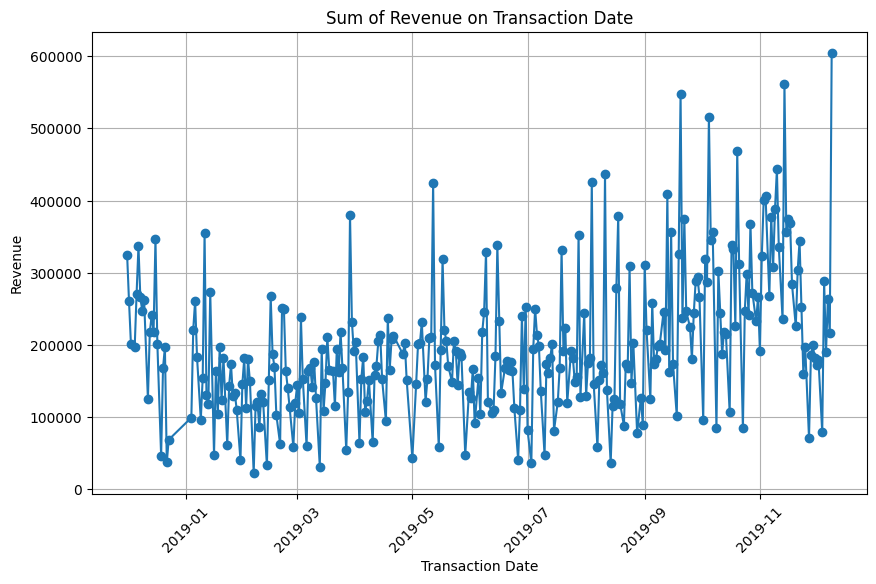

In [ ]:
# 1.2.3. Plot the sum of revenue on "transaction_date"
import matplotlib.pyplot as plt

# Group by transaction_date and sum the revenue
df_pandas_grouped = df_pandas.groupby('transaction_date')['Revenue'].sum().reset_index()

# Plot the result
plt.figure(figsize=(10, 6))
plt.plot(df_pandas_grouped['transaction_date'], df_pandas_grouped['Revenue'], marker='o')
plt.title('Sum of Revenue on Transaction Date')
plt.xlabel('Transaction Date')
plt.ylabel('Revenue')
plt.grid(True)
plt.xticks(rotation=45)
plt.show()


Observation:
1. The data demonstrates a large variations in daily revenue, with notable spikes on certain days.
2. Over time, there is an obvious rise trend in revenue, particularly since mid-2019, which could be given to seasonality or successful business activities.
3. The periodic spikes indicate that some days or periods frequently create higher revenue, pointing to likely recurring trends in customer behavior or marketing activity, such as the effects of promotions, special events.

### Question 1.3

The following code is to determines which workday generates the highest average sales revenue.

First, it extracts the day of the week from the transaction date, where 0 represents Monday and 6 represents Sunday.

It then groups the data by the day of the week and calculates the average revenue for each day.

Afterward, it maps the numerical weekdays to their respective names (e.g., Monday, Tuesday) for better readability.

A line plot is created to visualize the average revenue for each workday, showing trends across the week.

Finally, the code identifies the workday with the highest average revenue and prints the result, helping to highlight the best-performing day in terms of sales.

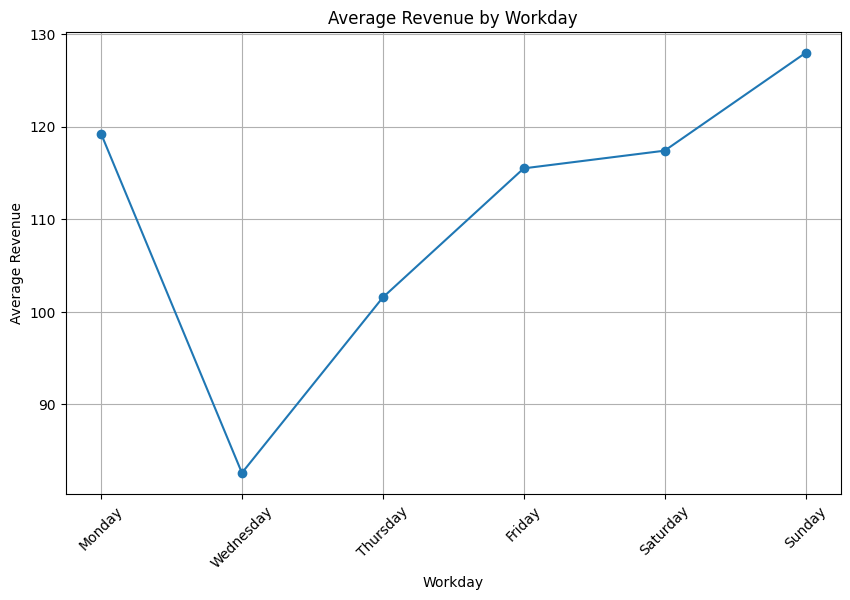

The workday with the highest average revenue is: Sunday


In [ ]:
# 1.3.1. Determine which workday generates the most sales

# Extract the day of the week (0 = Monday, 6 = Sunday)
df_pandas['weekday'] = df_pandas['transaction_date'].dt.dayofweek

# Calculate the average revenue for each workday
average_revenue_per_day = df_pandas.groupby('weekday')['Revenue'].mean().reset_index()

# Map weekdays to their names
average_revenue_per_day['weekday_name'] = average_revenue_per_day['weekday'].map({
    0: 'Monday', 1: 'Tuesday', 2: 'Wednesday', 3: 'Thursday',
    4: 'Friday', 5: 'Saturday', 6: 'Sunday'
})

# Plotting the average revenue per workday
plt.figure(figsize=(10, 6))
plt.plot(average_revenue_per_day['weekday_name'], average_revenue_per_day['Revenue'], marker='o')
plt.title('Average Revenue by Workday')
plt.xlabel('Workday')
plt.ylabel('Average Revenue')
plt.grid(True)
plt.xticks(rotation=45)
plt.show()

# Find the workday with the highest average revenue
max_revenue_day = average_revenue_per_day.loc[average_revenue_per_day['Revenue'].idxmax()]['weekday_name']
print(f"The workday with the highest average revenue is: {max_revenue_day}")




The following code identifies the top contributing product by revenue and sales volume on the workday with the highest average revenue (max_revenue_day).

First, it maps the name of the max_revenue_day (e.g., "Monday") to its corresponding integer value (e.g., 0 for Monday) using the weekday_mapping dictionary. Then, it filters the Pandas DataFrame to include only the transactions that occurred on this specific day.

Next, it determines the product with the highest total revenue on that day by grouping the data by productName_process and summing up the Revenue for each product.

The idxmax() function is used to find the product with the highest revenue. Similarly, the code also identifies the product with the highest sales volume by summing up the Quantity for each product and using idxmax() to find the product that sold the most units on that day.

Finally, both the top revenue-generating product and the top-selling product by volume are printed for the workday with the highest average revenue.

In [ ]:
# 1.3.2 Identify the top contributing product on the max_revenue_day

# Filter data for the identified workday
weekday_mapping = {
    'Monday': 0, 'Tuesday': 1, 'Wednesday': 2, 'Thursday': 3,
    'Friday': 4, 'Saturday': 5, 'Sunday': 6
}
# Get the integer representation of the max revenue day
max_revenue_day_int = weekday_mapping[max_revenue_day]

df_workday = df_pandas[df_pandas['weekday'] == max_revenue_day_int]

# Find the product that contributes the highest revenue on that workday
top_revenue_product = df_workday.groupby('productName_process')['Revenue'].sum().idxmax()

# Find the product that has the highest sales volume (sum of Quantity) on that workday
top_sales_volume_product = df_workday.groupby('productName_process')['Quantity'].sum().idxmax()

print(f"On {max_revenue_day}, the product with the highest revenue is: {top_revenue_product}")
print(f"On {max_revenue_day}, the product with the highest sales volume is: {top_sales_volume_product}")



On Sunday, the product with the highest revenue is: WorldWarGlidersAsstdDesigns
On Sunday, the product with the highest sales volume is: WorldWarGlidersAsstdDesigns


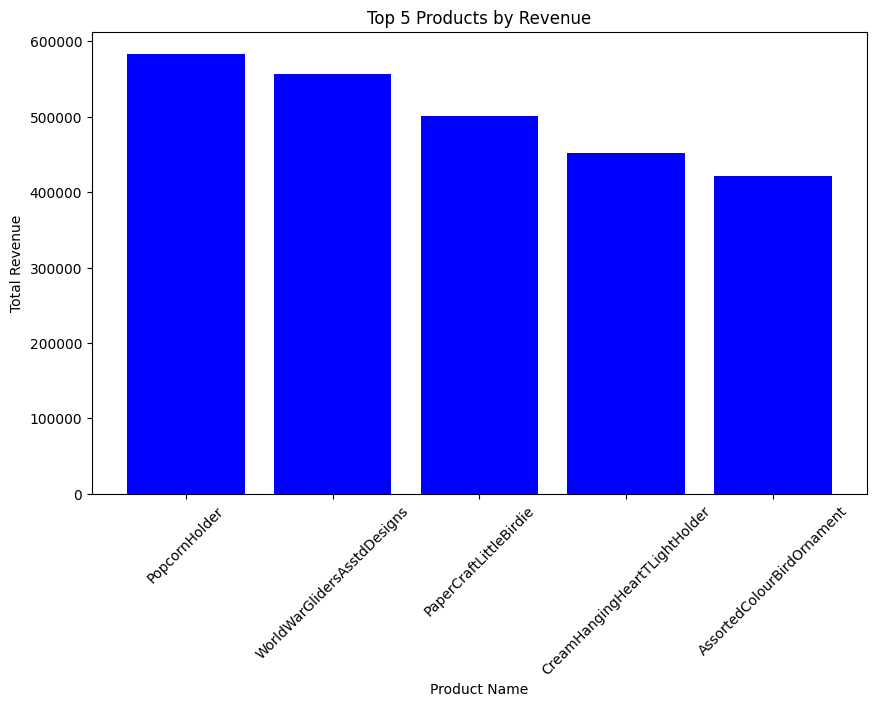

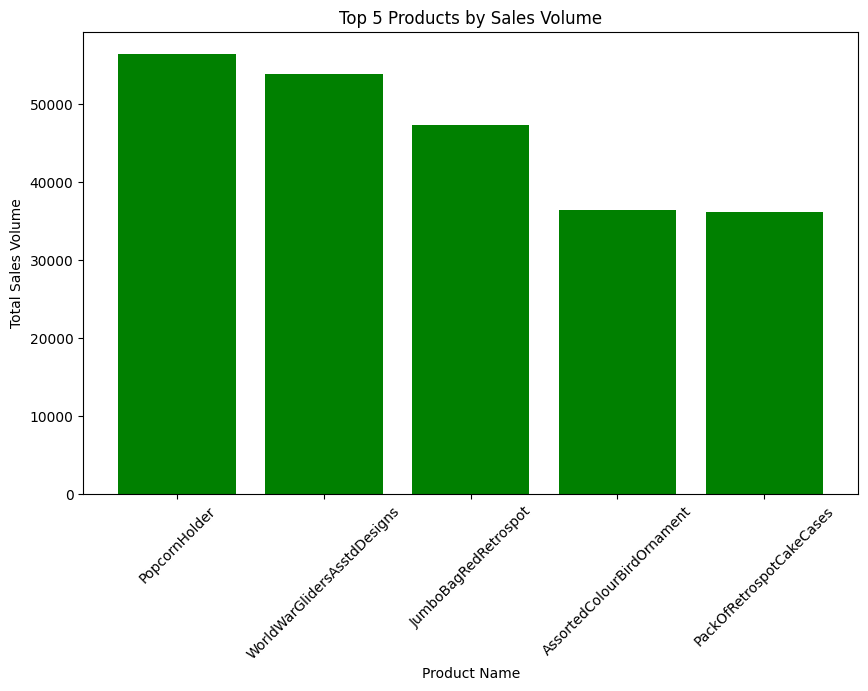

In [ ]:
# 1.3.3 Generate the two plots

import matplotlib.pyplot as plt

# Calculate total revenue and total sales volume for each product
total_revenue_per_product = df_pandas.groupby('productName_process')['Revenue'].sum().reset_index()
total_sales_volume_per_product = df_pandas.groupby('productName_process')['Quantity'].sum().reset_index()

# Get the top 5 products by revenue
top_5_revenue_products = total_revenue_per_product.sort_values(by='Revenue', ascending=False).head(5)

# Plot the top 5 products by revenue
plt.figure(figsize=(10, 6))
plt.bar(top_5_revenue_products['productName_process'], top_5_revenue_products['Revenue'], color='blue')
plt.title('Top 5 Products by Revenue')
plt.xlabel('Product Name')
plt.ylabel('Total Revenue')
plt.xticks(rotation=45)
plt.show()

# Get the top 5 products by sales volume
top_5_sales_volume_products = total_sales_volume_per_product.sort_values(by='Quantity', ascending=False).head(5)

# Plot the top 5 products by sales volume
plt.figure(figsize=(10, 6))
plt.bar(top_5_sales_volume_products['productName_process'], top_5_sales_volume_products['Quantity'], color='green')
plt.title('Top 5 Products by Sales Volume')
plt.xlabel('Product Name')
plt.ylabel('Total Sales Volume')
plt.xticks(rotation=45)
plt.show()



###Question1.4

The following code analyzes revenue by country and month, identifying the top-performing country and its highest-revenue month.

First, it calculates the total revenue for each country by grouping the data by the Country column and summing up the Revenue. The country with the highest revenue is determined and stored as top_revenue_country.

Then, the data is filtered for this country, and the month is extracted from the transaction_date to calculate the total monthly revenue. The code identifies the month with the highest revenue in that country, and finally, it optionally visualizes the monthly revenue trends using a line plot, with labels and a grid for clarity.

The country with the highest revenue is: United Kingdom
The month with the highest revenue in United Kingdom is: 2019-11


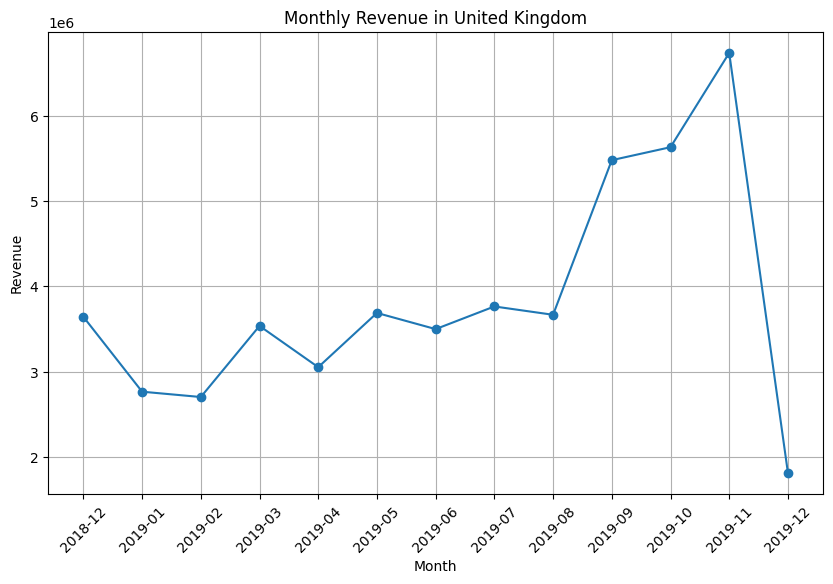

In [ ]:
import pandas as pd

# 1. Calculate total revenue by country
total_revenue_by_country = df_pandas.groupby('Country')['Revenue'].sum().reset_index()

# 2. Identify the country with the highest revenue
top_revenue_country = total_revenue_by_country.loc[total_revenue_by_country['Revenue'].idxmax(), 'Country']
print(f"The country with the highest revenue is: {top_revenue_country}")

# 3. Filter the data for the top revenue country
df_top_country = df_pandas[df_pandas['Country'] == top_revenue_country].copy()

# Extract the month from the transaction date using .loc to avoid the warning
df_top_country.loc[:, 'Month'] = df_top_country['transaction_date'].dt.to_period('M')

# 4. Calculate the total revenue by month for the top revenue country
monthly_revenue_in_top_country = df_top_country.groupby('Month')['Revenue'].sum().reset_index()

# Identify the month with the highest revenue
top_revenue_month = monthly_revenue_in_top_country.loc[monthly_revenue_in_top_country['Revenue'].idxmax(), 'Month']
print(f"The month with the highest revenue in {top_revenue_country} is: {top_revenue_month}")

# Plot the monthly revenue for the top revenue country
plt.figure(figsize=(10, 6))
plt.plot(monthly_revenue_in_top_country['Month'].astype(str), monthly_revenue_in_top_country['Revenue'], marker='o')
plt.title(f'Monthly Revenue in {top_revenue_country}')
plt.xlabel('Month')
plt.ylabel('Revenue')
plt.grid(True)
plt.xticks(rotation=45)
plt.show()




###Question1.5

In [ ]:
# Print the column names of the DataFrame
print(df_valid_shopping.columns)


Index(['TransactionNo', 'Date', 'ProductNo', 'ProductName', 'Product_category',
       'Price', 'Quantity', 'CustomerNo', 'Country', 'productName_process',
       'Revenue', 'transaction_date', 'weekday'],
      dtype='object')


The following code identifies the customer with the highest shopping frequency and analyzes the products they typically buy.

First, it filters out invalid transactions by retaining only those with a positive quantity. Then, it calculates the shopping frequency for each customer by counting the number of distinct transactions they have made. The customer with the highest frequency is identified and printed along with their total number of distinct transactions.

Next, the code focuses on this customer’s purchasing behavior by grouping their purchases by product and summing the total quantity bought. The products are then sorted in descending order based on the quantity purchased, allowing for an analysis of the most frequently bought items by this customer.

In [ ]:
# Step 1: Filter transactions with Quantity > 0 (valid shopping activities)
df_valid_shopping = df_pandas[df_pandas['Quantity'] > 0]

# Step 2: Calculate the shopping frequency (distinct TransactionNo) for each customer
customer_shopping_frequency = df_valid_shopping.groupby('CustomerNo')['TransactionNo'].nunique().reset_index()

# Step 3: Identify the customer with the highest shopping frequency
most_frequent_customer = customer_shopping_frequency.loc[customer_shopping_frequency['TransactionNo'].idxmax(), 'CustomerNo']
highest_frequency = customer_shopping_frequency['TransactionNo'].max()

print(f"The customer who shops most frequently is: {most_frequent_customer} with {highest_frequency} distinct transactions.")

# Step 4: Analyze the products typically bought by this customer based on Quantity
customer_products = df_valid_shopping[df_valid_shopping['CustomerNo'] == most_frequent_customer]
products_bought = customer_products.groupby('productName_process')['Quantity'].sum().reset_index()

# Sort the products by quantity in descending order to see the most frequently purchased products
products_bought = products_bought.sort_values(by='Quantity', ascending=False)

print(f"Products typically bought by customer {most_frequent_customer}:")
print(products_bought)


The customer who shops most frequently is: 12748 with 207 distinct transactions.
Products typically bought by customer 12748:
                productName_process  Quantity
1609   VictorianMetalPostcardSpring       595
1706    WorldWarGlidersAsstdDesigns       480
1273  RoseScentCandleJewelledDrawer       408
201         CartoonPencilSharpeners       405
1483    SmallWhiteRetrospotMugInBox       390
...                             ...       ...
989                PantryAppleCorer         1
507           FrenchCarriageLantern         1
508       FrenchChateauLargePlatter         1
986    PairOfPinkFlowerClusterSlide         1
1749      dVintageChristmasStickers         1

[1750 rows x 2 columns]
